# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import pickle
import matplotlib.pyplot as plt
import random
import numpy as np 
import cv2
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import PIL
from PIL import Image
import os
import os.path

%matplotlib inline


# Training and testing saved data paths
training_file = "../data/train.p"
validation_file= "../data/valid.p"
testing_file = "../data/test.p"

# Loading pickled data
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# Features and labels assignment
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# Traffic sign image size
image_shape = X_train[0].shape

# Unique classes number
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


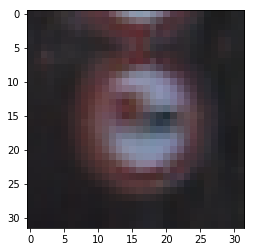

In [7]:
label_num = 10
plt.imshow(X_train[y_train == label_num][9])

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

26


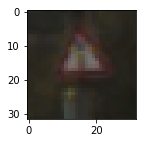

In [4]:
# A random traffic sign image visualization
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(2,2))
plt.imshow(image, cmap="gray")
# Printing Class Id
print(y_train[index])

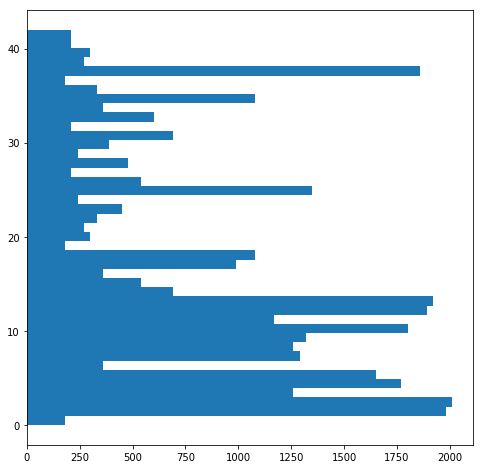

In [5]:
# Dataset exploratory visualization
# Count of each sign (in training set) as a histogram
plt.figure(figsize=(8,8))
plt.hist(y_train, bins = 43, orientation="horizontal")
plt.show()

In [7]:

np.array([len(y_train[y_train==13]),
         len(y_train[y_train==35]),
         len(y_train[y_train==23]),
         len(y_train[y_train==14]),
         len(y_train[y_train==11]),
         len(y_train[y_train==20])])

array([1920, 1080,  450,  690, 1170,  300])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the **number of classes** and possibly the **preprocessing**, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [5]:
# Preprocessing functions
# Grayscaling
def grayscale(image_data):
    return np.sum(image_data/3, axis=3, keepdims=True)

# Min-max normalization 
def normalize (gray):   
    a = 0.1
    b = 0.9
    x_min = 0
    x_max = 255
    return [a + ((b-a)*(i-x_min)/(x_max-x_min)) for i in gray]

In [6]:
# Applying grayscaling and normalization to dataset
X_train = normalize(grayscale(X_train))
X_valid = normalize(grayscale(X_valid))
X_test = normalize(grayscale(X_test)) 

### Model Architecture

In [7]:
# Model Hyperparameters

# Number of Epochs
EPOCHS = 23

# Batch size
BATCH_SIZE = 80

# Learning rate
learn_rate = 0.001

#Model Architecture
def LeNet(x):    
    
    # Mean (mu) and Standard deviation (sigma) for definition of weights and biases
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional layer. Input = 32x32x1. Output = 28x28x6.
    # Normally distributed weights
    wc1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    # Normally distributed biases
    bc1 = tf.Variable(tf.zeros(6))
    # Applying Covolutional layer
    conv1 = tf.nn.conv2d(x, wc1, strides = [1, 1, 1, 1] , padding ='VALID') + bc1
    
    # ReLU Activation (introducing non-linearities to the system)
    conv1 = tf.nn.relu(conv1)
    # Pooling/Subsambling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='VALID')
    # Layer 2: Convolutional layer. input = 14x14x6. Output = 10x10x16.
    wc2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    bc2 = tf.Variable(tf.zeros(16))   
    conv2 = tf.nn.conv2d(conv1, wc2, strides = [1, 1, 1, 1] , padding = 'VALID') + bc2
    
    # ReLU Activation.
    conv2 = tf.nn.relu(conv2)
    # Pooling/Subsambling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='VALID')
    
    # Flatten Convolution output. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    # Layer 3: Fully Connected layer. Input = 400. Output = 120.
    wfc1 = tf.Variable(tf.truncated_normal(shape=(400, 120),  mean = mu, stddev = sigma))
    bfc1 = tf.Variable(tf.zeros(120))   
    fc1 = tf.matmul(fc0, wfc1) + bfc1
    # ReLU Activation.
    fc1 = tf.nn.relu(fc1)
    # Dropout 1
    fc1= tf.nn.dropout(fc1, keep_prob)
    # Layer 4: Fully Connected layer. Input = 120. Output = 84.
    wfc2 = tf.Variable(tf.truncated_normal(shape=(120, 84),  mean = mu, stddev = sigma))
    bfc2 = tf.Variable(tf.zeros(84))   
    fc2 = tf.matmul(fc1, wfc2) + bfc2
    # ReLU Activation.
    fc2 = tf.nn.relu(fc2)
    # Dropout 2
    fc2= tf.nn.dropout(fc2, keep_prob)
    # Layer 5: Fully Connected layer. Input = 84. Output = 43.
    wfc3 = tf.Variable(tf.truncated_normal(shape=(84, 43),  mean = mu, stddev = sigma))
    bfc3 = tf.Variable(tf.zeros(43))   
    logits = tf.matmul(fc2, wfc3) + bfc3
    logits = tf.nn.dropout(logits, keep_prob)
    return logits

# Placeholders with None size to store any batch size
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

# Probability to keep units in Dropout
keep_prob = tf.placeholder(tf.float32)

#One-hot encoding
one_hot_y = tf.one_hot(y, 43)


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [8]:
# Training pipeline

logits = LeNet(x)
# Comparing logits to ground truth labels to calculate the c-e 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
# Averages the c-e from all of the training images
loss_operation = tf.reduce_mean(cross_entropy)
# Loss function minimization
optimizer = tf.train.AdamOptimizer(learning_rate = learn_rate)
# Training loss minimizaion using backprop
training_operation = optimizer.minimize(loss_operation)
# Comparing the logit prediction to the one-hot encoded ground truth label
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
# Model overall accuracy (individual prediction accuracies)
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# Creating Saver class to restore saved model
saver = tf.train.Saver()

In [9]:
# Evaluation function (for accuracy calculation) 
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    # Batches the dataset and runs it through the evaluation pipeline
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [10]:
# Model training 

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...")
    print()
    # History lists for learning curves 
    train_acc_hist = []
    valid_acc_hist = []
    for i in range(EPOCHS):
        # Avoiding biasing by shuffling at Epoch beginning
        X_train, y_train = shuffle(X_train, y_train)
        # Training data batching
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            train_acc_hist.append(evaluate(batch_x, batch_y))
            # Keeping probablities of activations using Dropout is 50%
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

        # Epoch accuracy evaluation
        validation_accuracy = evaluate(X_valid, y_valid)
        valid_acc_hist.append(evaluate(X_valid, y_valid))
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    # Saving trained model
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.396

EPOCH 2 ...
Validation Accuracy = 0.662

EPOCH 3 ...
Validation Accuracy = 0.768

EPOCH 4 ...
Validation Accuracy = 0.819

EPOCH 5 ...
Validation Accuracy = 0.845

EPOCH 6 ...
Validation Accuracy = 0.860

EPOCH 7 ...
Validation Accuracy = 0.867

EPOCH 8 ...
Validation Accuracy = 0.885

EPOCH 9 ...
Validation Accuracy = 0.885

EPOCH 10 ...
Validation Accuracy = 0.916

EPOCH 11 ...
Validation Accuracy = 0.914

EPOCH 12 ...
Validation Accuracy = 0.915

EPOCH 13 ...
Validation Accuracy = 0.929

EPOCH 14 ...
Validation Accuracy = 0.937

EPOCH 15 ...
Validation Accuracy = 0.935

EPOCH 16 ...
Validation Accuracy = 0.938

EPOCH 17 ...
Validation Accuracy = 0.934

EPOCH 18 ...
Validation Accuracy = 0.942

EPOCH 19 ...
Validation Accuracy = 0.946

EPOCH 20 ...
Validation Accuracy = 0.942

EPOCH 21 ...
Validation Accuracy = 0.948

EPOCH 22 ...
Validation Accuracy = 0.952

EPOCH 23 ...
Validation Accuracy = 0.950

Model saved


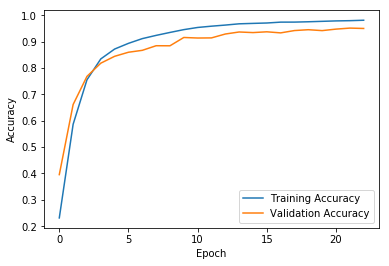

In [11]:
# Learning curves 

train_acc_avg = []
batch_per_epoch = np.int(np.ceil(num_examples / BATCH_SIZE))
for k in range (0, EPOCHS, 1):
    # Averaging training accuracy of each epoch
    train_acc_avg.append(np.mean(train_acc_hist[k*batch_per_epoch:(k+1)*batch_per_epoch]))

x_points = np.linspace(0,EPOCHS-1,num=EPOCHS)
plt.plot(x_points, train_acc_avg)
plt.plot(x_points, valid_acc_hist)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

In [12]:
# Test set accuracy
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './lenet')
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.923


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

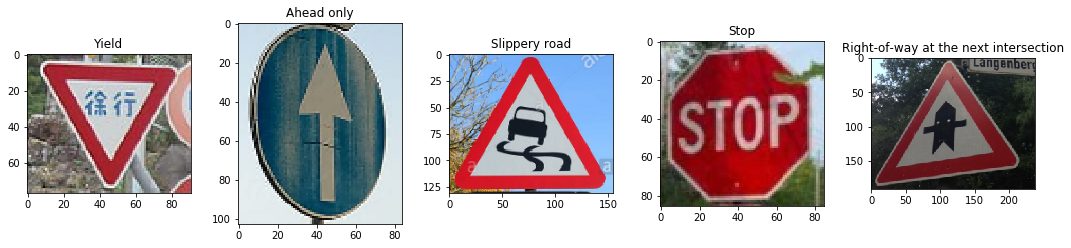

In [13]:
raw_imgs = []
test_path = r'test_images'

raw_imgs = [Image.open(test_path+"/"+file) 
            for file in sorted(os.listdir(test_path))]

# Output of new images
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(14, 14))
f.tight_layout()
ax1.imshow(raw_imgs[0])
ax1.set_title('Yield', fontsize=12) #Label: 13
ax2.imshow(raw_imgs[1])
ax2.set_title('Ahead only', fontsize=12) #Label: 35
ax3.imshow(raw_imgs[2])
ax3.set_title('Slippery road', fontsize=12) #Label: 23
ax4.imshow(raw_imgs[3])
ax4.set_title('Stop', fontsize=12) # Label: 14
ax5.imshow(raw_imgs[4])
ax5.set_title('Right-of-way at the next intersection', fontsize=12) # Label: 11
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Predict the Sign Type for Each Image

In [14]:
#Preprocessing images

#Resizing to 32x32 px
resized_imgs = []
for file in sorted(os.listdir(test_path)):
    f_img = test_path+"/"+file
    img = cv2.imread(f_img)
    img = cv2.resize(img, dsize=(32, 32))   
    resized_imgs.append(img)

# Applying grayscaling and normalization
test_imgs = []
for i in range(0, len(resized_imgs)):
    #Expand dimensions to add the channel dim (to match placeholder)
    test_imgs.append(np.expand_dims(normalize(cv2.cvtColor(resized_imgs[i],cv2.COLOR_BGR2GRAY)),axis=2))

### Analyze Performance

In [15]:
# New images accuracy calculation
test_true_labels = np.array([13,35,23,14,11])
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './lenet')
    # keep_prob should equal to 1 during testing
    test_logits = sess.run(logits, feed_dict = {x: test_imgs, keep_prob: 1})
    test_pred_labels = np.argmax(test_logits, axis = 1)
    print(test_pred_labels)
    test_accuracy = evaluate(test_imgs, test_true_labels)
    print("New images test accuracy = {:.2f}".format(test_accuracy))


INFO:tensorflow:Restoring parameters from ./lenet
[13 35 11 14 20]
New images test accuracy = 0.60


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './lenet')
    # Print softmax 5 top softmax probablities and their corresponding labels
    softmax_probs = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict = {x: test_imgs,  keep_prob : 1})
    print(softmax_probs)

INFO:tensorflow:Restoring parameters from ./lenet
TopKV2(values=array([[  1.00000000e+00,   1.82464330e-20,   2.65232838e-21,
          6.47943640e-22,   6.61497040e-23],
       [  9.99920964e-01,   2.65869421e-05,   1.15606699e-05,
          1.06982670e-05,   8.86107591e-06],
       [  9.82652068e-01,   1.17717953e-02,   4.50878730e-03,
          5.51657169e-04,   2.48521945e-04],
       [  4.81991678e-01,   3.28421265e-01,   1.36018947e-01,
          7.64729874e-03,   7.06240861e-03],
       [  1.61660954e-01,   1.45901859e-01,   9.50845927e-02,
          9.24063995e-02,   6.67097121e-02]], dtype=float32), indices=array([[13, 35, 25, 15, 34],
       [35, 25, 34, 33,  3],
       [11, 23, 30, 34, 42],
       [14,  4,  5,  1, 13],
       [20, 25, 10, 11,  5]], dtype=int32))
